# Performing hypothesis testing in Python

# 1 Preparing Data for Hypothesis Testing

### Combines pandas, scipy.stats and statsmodels to get more complete information in  single API call

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import researchpy as rp
import missingno as msno

from sklearn.preprocessing import scale
from scipy import stats

plt.style.use('fivethirtyeight')
%matplotlib inline

### The bike_sharing dataset
url = "https://www.kaggle.com/lakshmi25npathi/bike-sharing-dataset"

## Import dataset

In [2]:
bs_dataset = pd.read_csv('day.csv')
bs_dataset.sample(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
135,136,2011-05-16,2,0,5,0,1,1,1,0.577500,0.550512,0.787917,0.126871,773,3185,3958
330,331,2011-11-27,4,0,11,0,0,0,1,0.459167,0.455800,0.698333,0.208954,810,2261,3071
536,537,2012-06-20,2,1,6,0,3,1,1,0.782500,0.720975,0.592083,0.113812,872,5339,6211
228,229,2011-08-17,3,0,8,0,3,1,1,0.723333,0.666671,0.575417,0.143667,668,4026,4694
575,576,2012-07-29,3,1,7,0,0,0,1,0.721667,0.667933,0.623750,0.170396,2153,4444,6597
263,264,2011-09-21,3,0,9,0,3,1,2,0.595000,0.550533,0.900000,0.096404,539,3813,4352
349,350,2011-12-16,4,0,12,0,5,1,2,0.375000,0.359825,0.500417,0.260575,178,3399,3577
565,566,2012-07-19,3,1,7,0,4,1,1,0.770000,0.714642,0.600417,0.165429,888,5703,6591
613,614,2012-09-05,3,1,9,0,3,1,1,0.736667,0.708983,0.741250,0.187808,832,6280,7112
494,495,2012-05-09,2,1,5,0,3,1,2,0.575000,0.553025,0.744167,0.216412,620,4097,4717


### Shape of data

In [3]:
bs_dataset.shape

(731, 16)

### We need [workingday, cnt] variables for the Test

In [4]:
bs_dataset = bs_dataset.loc[:, [
    'season',
    'mnth',
    'holiday',
    'workingday',
    'weathersit',
    'temp',
    'cnt'
]]

In [5]:
bs_dataset.to_csv('bike_share.csv', index=False)

In [6]:
bs_dataset.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


In [7]:
bs_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   mnth        731 non-null    int64  
 2   holiday     731 non-null    int64  
 3   workingday  731 non-null    int64  
 4   weathersit  731 non-null    int64  
 5   temp        731 non-null    float64
 6   cnt         731 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 40.1 KB


### Missing values

<AxesSubplot:>

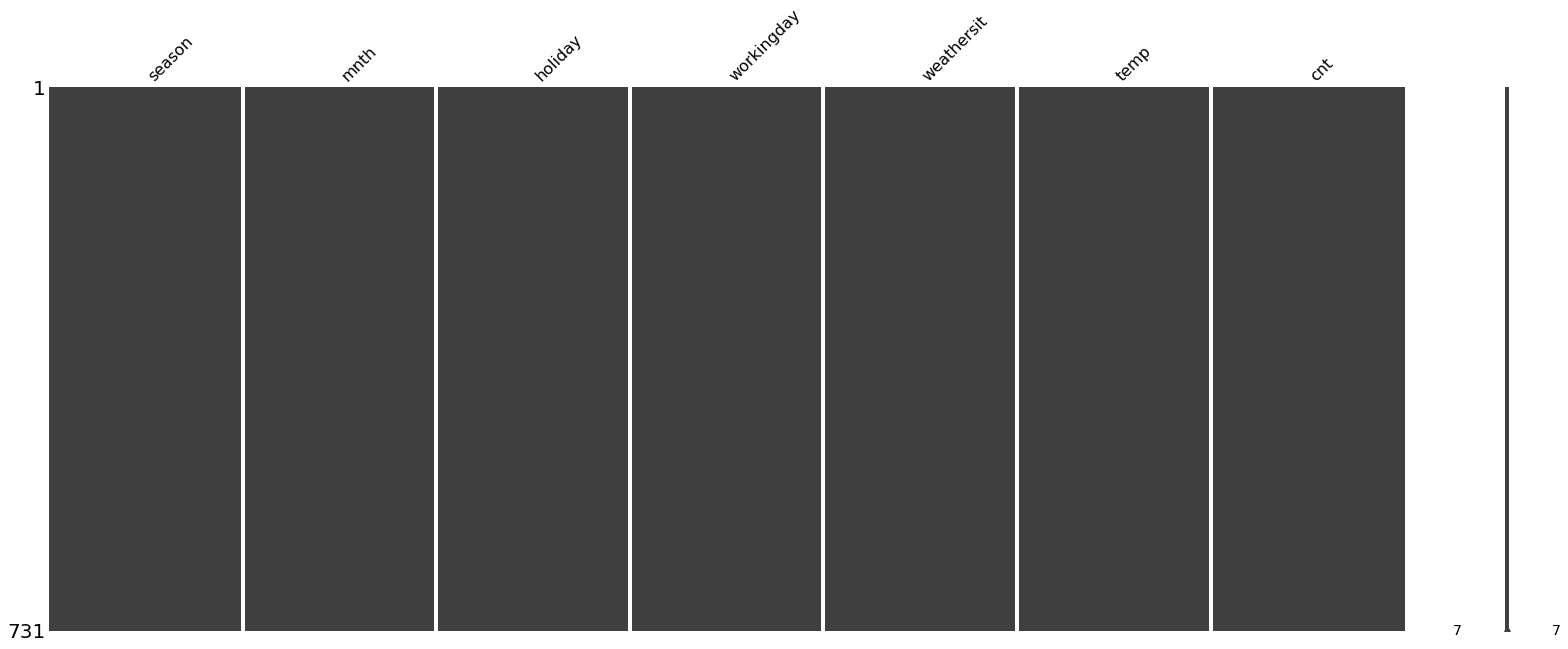

In [8]:
msno.matrix(bs_dataset, figsize=(24,10))

**No data missing**

In [9]:
# season
bs_dataset.loc[:, 'season'].unique()

array([1, 2, 3, 4])

In [10]:
bs_dataset.loc[:, 'season'].nunique()

4

1: spring <br>
2: summer <br>
3: autumn <br>
4: winter

In [11]:
# workingday
bs_dataset.loc[:, 'workingday'].unique()

array([0, 1])

In [12]:
# holiday
bs_dataset.loc[:, 'holiday'].unique()

array([0, 1])

In [13]:
# weathesit
bs_dataset.loc[:, 'weathersit'].unique()

array([2, 1, 3])

1: clear, few clouds
2: Misty cloudy
3: light snow, rain, thunderstorm

In [14]:
bs_dataset.loc[:,'temp'].describe()

count    731.000000
mean       0.495385
std        0.183051
min        0.059130
25%        0.337083
50%        0.498333
75%        0.655417
max        0.861667
Name: temp, dtype: float64

In [15]:
bs_dataset.groupby('workingday')['cnt'].describe().T

workingday,0,1
count,231.000000,500.000000
mean,4330.168831,4584.820000
std,2052.141245,1878.415583
min,605.000000,22.000000
25%,2710.500000,3344.250000
50%,4459.000000,4582.000000
75%,5907.500000,5987.500000
max,8714.000000,8362.000000


#### We will use the t-test to compare the two sampling means from the working days to see if the difference is significant or not.

## Visualizing data

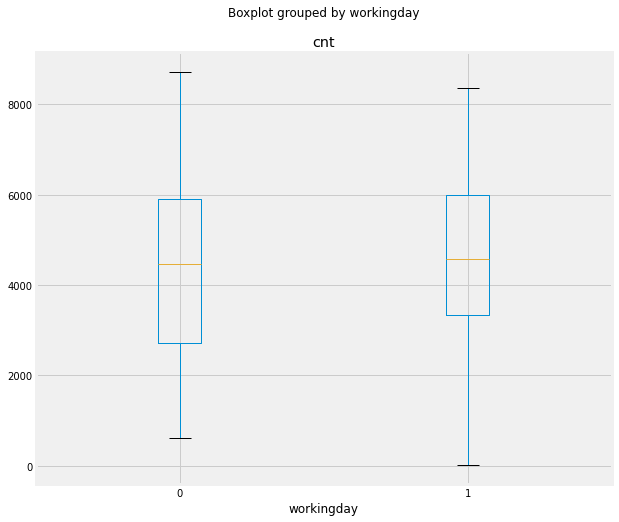

In [16]:
# trace a boxplot 
bs_dataset.boxplot(column=['cnt'], by='workingday', figsize=(10,8))
plt.show()

## Objectif

We notice a difference between the means, but we want to know if it is due to a fluctuation of the samples or it is due to the workingday variable.

## Samples

In [17]:
sample1 = bs_dataset.loc[bs_dataset.loc[:, 'workingday'] == 1]
sample2 = bs_dataset.loc[bs_dataset.loc[:, 'workingday'] == 0]

In [18]:
sample1.shape, sample2.shape

((500, 7), (231, 7))

In [19]:
sample1 = sample1.sample(sample2.shape[0])
sample1.shape

(231, 7)

# 2 Performing the independent t-test

Check the variability if is the same or not by **levene's test**

In [20]:
stats.levene(sample1['cnt'], sample2['cnt'])

LeveneResult(statistic=0.8622126028327896, pvalue=0.3536072264568768)

### It can be seen that the two samples have the same variability since the $\alpha=0.05 < p-value=0.353$

## The distribution of the residuals between the two groups

#### It should follow the normal distribution

In [21]:
diff = scale(np.array(sample1['cnt'], dtype=np.float) - np.array(sample2['cnt'], dtype=np.float))

(array([ 2., 13., 13., 31., 40., 38., 42., 30., 14.,  8.]),
 array([-2.69096818, -2.19283253, -1.69469688, -1.19656123, -0.69842558,
        -0.20028994,  0.29784571,  0.79598136,  1.29411701,  1.79225266,
         2.29038831]),
 <BarContainer object of 10 artists>)

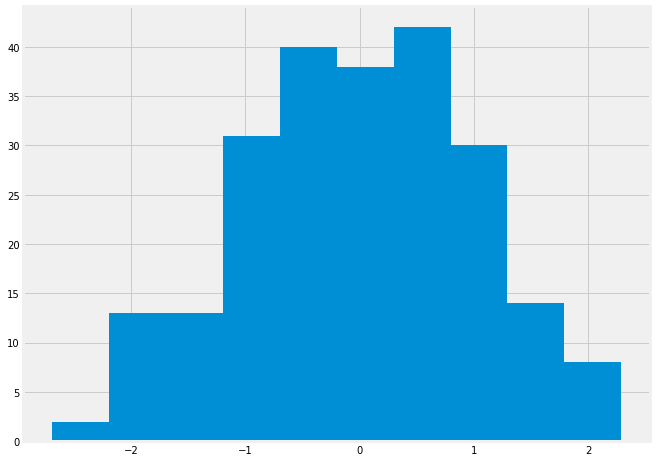

In [22]:
plt.figure(figsize=(10, 8))
plt.hist(diff)

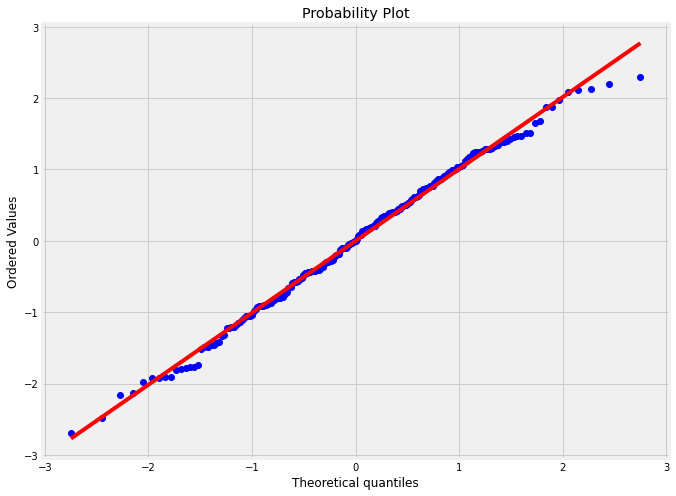

In [23]:
plt.figure(figsize=(10, 8))
stats.probplot(diff, dist='norm', plot=plt)
plt.show()

In [24]:
stats.shapiro(diff)

(0.9939827919006348, 0.4834084212779999)

### So, the distribution of the residuals between the two groups follow the normal distribution

# 3 Setting up the test

## $$H_0: \mu_0 = \mu_1$$
## $$H_1: \mu_0 \neq \mu_1$$

## Perform t_test

In [25]:
stats.ttest_ind(sample1['cnt'], sample2['cnt'])

Ttest_indResult(statistic=1.2577176337812208, pvalue=0.20913199381473951)

### p-value = 0.209 is not significant, so we can't reject the null hypotesis, then we accept H0. The means are equals


In [26]:
descriptives, results = rp.ttest(sample1['cnt'], sample2['cnt'])

In [27]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,cnt,231.0,4565.000000,1960.027118,128.960316,4310.905391,4819.094609
1,cnt,231.0,4330.168831,2052.141245,135.020981,4064.132702,4596.204960
2,combined,462.0,4447.584416,2007.878746,93.414973,4264.012482,4631.156349


In [28]:
results

,Independent t-test,results
0,Difference (cnt - cnt) =,234.8312
1,Degrees of freedom =,460.0000
2,t =,1.2577
3,Two side test p value =,0.2091
4,Difference < 0 p value =,0.8954
5,Difference > 0 p value =,0.1046
6,Cohen's d =,0.1170
7,Hedge's g =,0.1168
8,Glass's delta =,0.1198
9,r =,0.0585
